## Utilizando RandomForest para predições de churn 

<i>Churn é uma métrica utilizada para verificar clientes que deixaram de utilizar determinado serviço</i>

In [1]:
!pip install -q -U watermark


# pip        >  gerenciador de pacotes python
# install    >  comando para instalar um novo pacote
# -q         >  para que os eventos durante instalação não sejam exibidos (-q = quiet)
# -U         >  para que toda a vez em que o processo de instalação ocorrer o pip busque a ultima versão do pacote
# watermark  >  pacote python para exibir versão, data da execução e informações do hardware

#### Importação de pacotes

In [2]:
import warnings
import joblib
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [3]:
warnings.filterwarnings('ignore')

#### Configuração para tamanho de gráficos

In [4]:
sns.set(style="whitegrid")

# Definindo que os gráficos devem ter uma dimensão de 6x5 (6 é largura e 5 a altura)
plt.rcParams['figure.figsize'] = [6, 5]

#### Determinando dados a serem utilizados pelo pacote watermark

In [5]:
%reload_ext watermark
%watermark -a "Octávio Duarte"

Author: Octávio Duarte



#### Carregando os dados

In [6]:
base = pd.read_csv('dataset.csv')

In [9]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Idade              1000 non-null   int64  
 1   UsoMensal          1000 non-null   int64  
 2   Plano              1000 non-null   object 
 3   SatisfacaoCliente  1000 non-null   int64  
 4   TempoContrato      1000 non-null   object 
 5   ValorMensal        1000 non-null   float64
 6   Churn              1000 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 54.8+ KB


#### Análise exploratória

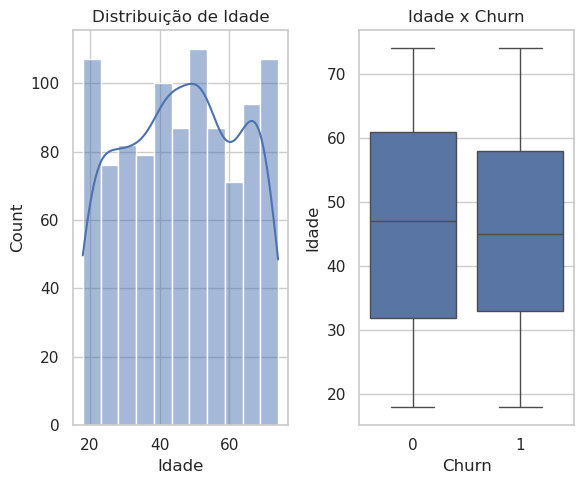

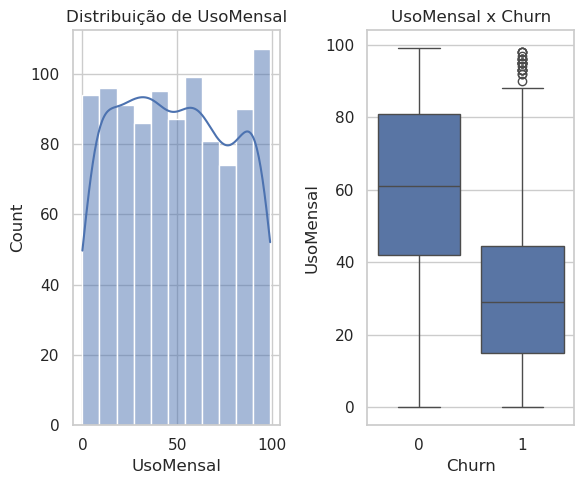

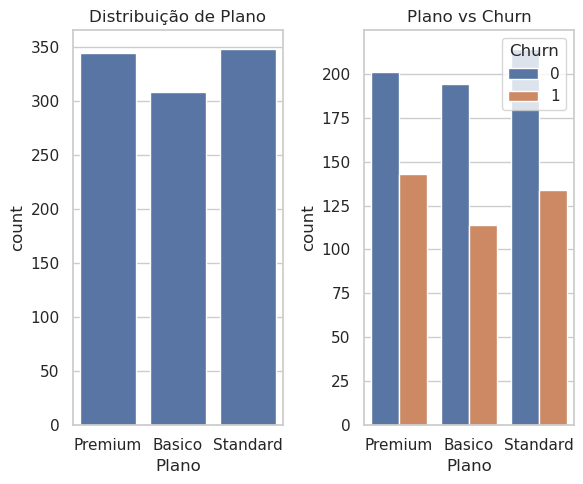

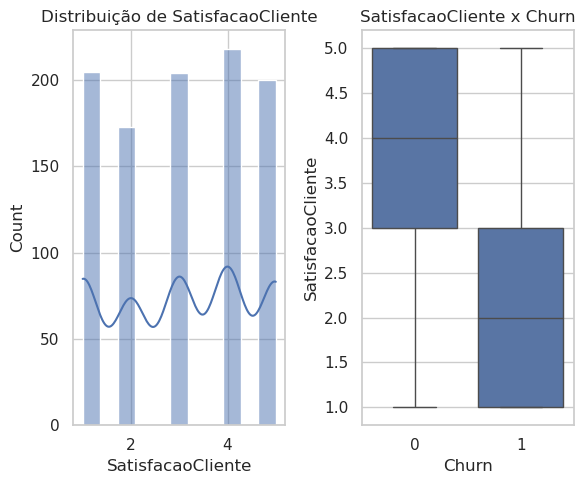

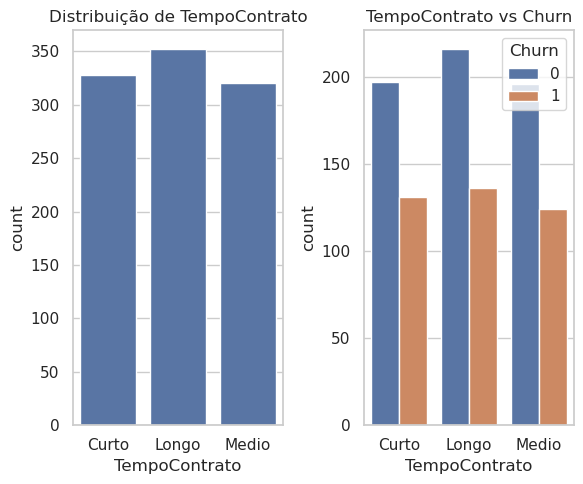

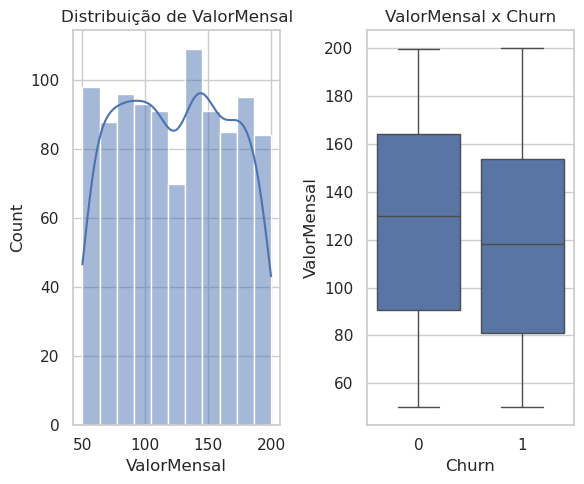

In [7]:
# Método que irá receber todo o conjunto de dados
def plot_feature_vs_target_comparison(data):
    # Variável que determina qual a target column
    target_column = "Churn"

    # Estrutura de repetição que terá para cada iteração o nome da coluna do DataFrame
    for column in data.columns:

    # Condicional que só sera atendida se  a coluna for do tipo inteiro, com ponto decimal
    #ou não for a coluna target
        
        if column != target_column:
            
            if data[column].dtype in ['int64', 'float64']:
                # Utilizamos o método subplot do matplotliib.pyplot - Instruímos para que ele gere o gráfico
                #com (1,2) - 1 figura com 2 gráficos  
                fig, (ax1, ax2) = plt.subplots(1, 2)
                
                # Determinamos as configurações do seaborn (que otimiza visualmente e abstrai a complexidade do matplotlib)
                sns.histplot(data[column], kde = True, ax = ax1)
                sns.boxplot(x = target_column, y = column, data = data, ax = ax2)
    
                # Determinamos os títulos dos 2 gráficos
                ax1.set_title(f"Distribuição de {column}")
                ax2.set_title(f"{column} x Churn")
    
                # Método .show que exibe os gráficos
                plt.tight_layout()
                plt.show()
                # Caso a coluna não seja do tipo númérica usaremos um gráfico do tipo 'countplot', que é um gráfico
                #que nos exibe a contagem de ocorrências de um determinado valor e lembrando que faremos isso
                #para cada coluna
            else:
                fig, (ax1, ax2) = plt.subplots(1, 2)
                
                sns.countplot(x = column, data = base, ax = ax1)
                sns.countplot(x = column, hue = 'Churn', data = base, ax = ax2)
                
                ax1.set_title(f'Distribuição de {column}')
                ax2.set_title(f'{column} vs Churn')
                
                plt.tight_layout()
                plt.show()

plot_feature_vs_target_comparison(base)

##### Resumo do método `plot_feature_vs_target_comparison`:

- Na primeira condicional estamos determinando que dois gráficos serão exibidos para todas as colunas numéricas, destes 2 gráficos temos as seguintes especificações:
  
    - O primeiro é do tipo  `histplot` e vai exibir a distribuição dos dados da coluna iterada na estrutura de reptição (o `for`) de forma univariada (univariada = analiso a distribuição dos dados sem considerar variações dos mesmos). 
 
    - O segundo é do tipo [`boxplot`](https://github.com/octavioduarte/DataScience/blob/master/08-um-pouco-sobre-o-pandas/30-boxplots.ipynb) e também vai exibir a distribuição dos dados da coluna iterada na estrutura de reptição, mas de forma bivariada (bivariada = analiso a distribuição dos dados considerando duas variações dos mesmos, no caso o cliente é da classe chrum ou não, ou seja, encerrou a contratação do serviço).


- Caso a coluna não seja numérica:

  - Usaremos um gráfico do tipo `countplot` útil para analisar a contagem de ocorrências. No primeiro gráfico temos o total de ocorrências exibido por cada categoria e no segundo um comparativo da quantidade de cada categoria com o total de casos de churn.

##### Analisando os gráficos da análise exploratória

> Coluna Idade

- Gráfico univariado: A coluna Idade tem seus valores bem distribuídos sem uma grande diferença em alguma faixa etária.

- Boxplot: A coluna Idade no boxplot não parece ter uma grande diferença entre clientes com encerrarm o serviço (classe 1) e os que permanecem (classe 0), logo não podemos até então considerar este um fator decisivo para determinar um caso de churn.

</br>

> Coluna UsoMensal

- Gráfico univariado: A coluna UsoMensal tem seus valores bem distribuídos sem um grande destaque
em qualquer nível de uso.

- Boxplot: Temos uma diferença considerável de uso neste caso - Clientes da classe 1 usaram consideravelmente menos o serviço (exceto por alguns [outliers](https://github.com/octavioduarte/DataScience/blob/master/08-um-pouco-sobre-o-pandas/15-identificando-outliers.ipynb)). Podemos considerar este um valor relevante para determinar ou não um caso de churn.

</br>

> Coluna Plano

- Gráfico univariado: A coluna Plano tem seus valores bem distribuídos, sem destaque para nenhuma categoria.

- Countplot: Não há um destaque em nenhuma categoria se compararmos os valores com as classes churn. Mas vale a observação de que a maioria dos casos de churn são para o plano Premium, o que  pode gerar um bom questionamento se o plano mais caro da empresa vale de fato a pena para seus clientes.


</br>

> Coluna SatisfacaoCliente

- Gráfico univariado: A coluna SatisfacaoCliente tem seus valores bem distribuídos, sem destaque para nenhum valor.

- Boxplot: Existe uma grande diferença de satisfação entre clientes da classe 0 e 1 de churn - Clientes da classe 1 tem como mediana a avaliação em 2 enquanto os da classe 0 ficam em 4; Além disso o Q3 é 3 para os clientes da classe 1 enquanto a classe 0 fica em 5. Esta é claramente uma coluna a ser considerarada para classificar um caso de churn.

</br>

> Coluna TempoContrato

- Gráfico univariado: A coluna TempoContrato tem seus valores bem distribuídos, sem destaque para nenhum valor.

- Countplot: Não há um destaque em nenhuma categoria se compararmos os valores com as classes churn. Não aparenta ser uma coluna determinante para classificar um caso de churn.


</br>

> Coluna ValorMensal

- Gráfico univariado: A coluna ValorMensal tem seus valores bem distribuídos sem uma grande diferença.

- Boxplot: A coluna ValorMensal no boxplot não parece ter uma grande diferença entre clientes com encerrarm o serviço (classe 1) e os que permanecem (classe 0), logo não podemos até então considerar este um fator decisivo para determinar um caso de churn.

#### Separando o conjunto de treino e teste

In [8]:
X = base.drop('Churn', axis=1)
y = base['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1977)

##### Formato dos nossos dados de treino e teste

In [31]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(700, 6) (300, 6) (700,) (300,)


- X_train >  700 linhas com 6 colunas
- X_test  >  300 linhas com 6 colunas

- y_train >  700 linhas com 1 coluna (nossa target_column) 
- y_test  >  300 linhas com 1 coluna (nossa target_column) 

#### Pré-processamento de dados

O pré processamento de dados é a etapa onde aplicamos normalização dos mesmos em um formato propício para o treinamento do modelo. Deve ser feito depois da separação dos conjuntos em treino e teste para que seja evitado o vazamento de informações do conjunto de teste para o conjunto de treino.

##### Convertendo as variáveis categóricas do tipo texto para um valor inteiro utilizando a técnica de One-Hot Encoding

One-Hot Encoding é uma técnica utilizada para renomear valores categóricos que estão em texto para números, mas em formato binário, exemplo:

| Cliente | Plano      |
|---------|------------|
| Ana     | Empresarial|
| Pedro   | Básico     |
| Maria   | Top        |

Modelos de classificação de Machine Learning não devem ser treinados com texto - Neste caso uma técnica seria uma simples conversão: 


| Cliente | Plano |
|---------|-------|
| Ana     | 2     |
| Pedro   | 1     |
| Maria   | 3     |

Isso já funcionaria, entretanto isso pode comprometer a níveis de performance e neste caso utilizamos a técnica do One-Hot Encoding que terá o mesmo objetivo, mas alcançado de uma forma diferente - Neste caso cada variação de classe é convertida para uma coluna e se um registro corresponder a classe o seu valor na coluna será 1, caso contrário 0, aqui um exemplo de como seria isso utilizando a tabela acima: 

| Cliente | Plano_Empresarial | Plano_Básico | Plano_Top  |
|---------|--------------------|--------------|-----------|
| Ana     | 1                  | 0            | 0         |
| Pedro   | 0                  | 1            | 0         |
| Maria   | 0                  | 0            | 1         |

In [12]:
# Extraindo nossas colunas categóricas do tipo object que na prática são valores textuais
categorical_columns = base.select_dtypes(include="object").columns

# Instaciamos a classe OneHotEncoder do módulo preprocessing do sklearn
encoder = OneHotEncoder(sparse_output= False)

# Utilizamos a função .fit_transform do objeto encoder - Estamos gerando matrizes com valores binários
#para o conjunto de treino e de teste
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_columns]))
X_test_encoded =  pd.DataFrame(encoder.transform( X_test[categorical_columns]))

# Atribuímos o valor das matrizes como colunas do Dataset
X_train_encoded.columns = encoder.get_feature_names_out(categorical_columns)
X_test_encoded.columns = encoder.get_feature_names_out(categorical_columns)

# Apagamos as colunas categórcas do DataFrame original
X_train_preprocessed = X_train.drop(categorical_columns, axis = 1).reset_index(drop = True)
X_test_preprocessed =  X_test.drop(categorical_columns, axis = 1 ).reset_index(drop = True)

# Utilizamos a função .concat do Pandas que vai unir os DataFrames passados em seu primeiro parâmetro
#Neste caso estamos unindo:

# O DataFrame com as colunas categóricas que tem seus  valores codificados em binário
# E o DataFrame original com as colunas categóricas removidas.
X_train_preprocessed = pd.concat([X_train_preprocessed, X_train_encoded], axis = 1)
X_test_preprocessed = pd.concat([X_test_preprocessed, X_test_encoded], axis = 1)

In [14]:
X_test_preprocessed.head()

,Idade,UsoMensal,SatisfacaoCliente,ValorMensal,Plano_Basico,Plano_Premium,Plano_Standard,TempoContrato_Curto,TempoContrato_Longo,TempoContrato_Medio
0,56,55,5,54.67,1.0,0.0,0.0,1.0,0.0,0.0
1,36,4,5,103.20,0.0,0.0,1.0,0.0,1.0,0.0
2,19,24,3,68.90,1.0,0.0,0.0,0.0,1.0,0.0
3,49,49,4,62.77,1.0,0.0,0.0,1.0,0.0,0.0
4,25,55,4,58.00,0.0,0.0,1.0,1.0,0.0,0.0


In [15]:
X_train_preprocessed.head()

,Idade,UsoMensal,SatisfacaoCliente,ValorMensal,Plano_Basico,Plano_Premium,Plano_Standard,TempoContrato_Curto,TempoContrato_Longo,TempoContrato_Medio
0,58,86,4,85.16,0.0,0.0,1.0,1.0,0.0,0.0
1,56,58,3,183.56,0.0,0.0,1.0,0.0,1.0,0.0
2,24,98,5,90.60,0.0,0.0,1.0,0.0,0.0,1.0
3,34,76,3,100.90,1.0,0.0,0.0,0.0,1.0,0.0
4,45,34,2,59.22,0.0,1.0,0.0,1.0,0.0,0.0


##### Aplicando o StandardScaler nas colunas numéricas.

 O StandardScaler é uma técnica de normalização de dados. Em resumo ele funciona assim:

- Passamos as colunas *numéricas* que desejamos normalizar.
- O StandardScaler vai aplicar para cada valor de cada coluna a seguinte fórmula:
 

    - `(x - u) / s`
    - Onde:
    - x = É o valor em questão
    - u = média da coluna onde o valor está inserido
    - s = [desvio padrão](https://www.youtube.com/watch?v=JEwd0Vlqapo) da coluna onde o valor está inserido
 
Ou seja para cada valor ele vai calcular a média da coluna, subtrair do valor em questão e dividir o resultado pelo desvio padrão.

##### Por que? 

 Alguns algoritmos de Machine Learning são sensíveis a grandeza dos valores - Imagine que desejo fazer uma predição  considerando o peso e o salário para determinar quantos pedidos vão ser feitos por determinado cliente em um fast food.

 São duas variáveis que tem uma forte tendência a terem uma escala de valores muito distantes. 

 Enquanto salários são calculados na casa de milhares o peso não passa de centenas e para alguns algoritimos de Machine Learning essa diferença pode fazer com que o peso da pessoa não seja tão considerado quanto o salário justamente por estar em uma escala menor de valor.

 O que o StandardScaler faz é aplicar uma escala "universal" de forma que os valores fiquem próximos entre si sem que a escala deles tenha uma relevância que não deveria no momento da predição.

 Pra concluir, depois de aplicar o StandardScaler: 

 - A média dos valores da coluna será igual a 0.
 - O [desvio padrão](https://www.youtube.com/watch?v=JEwd0Vlqapo) será igual a 1.

In [49]:
numeric_columns = X_train_preprocessed.select_dtypes(include = ['int64', 'float64']).columns

scaler = StandardScaler()

X_train_preprocessed[numeric_columns] = scaler.fit_transform(X_train_preprocessed[numeric_columns])
X_test_preprocessed[numeric_columns] = scaler.transform(X_test_preprocessed[numeric_columns])

In [50]:
X_train_preprocessed.head()

,Idade,UsoMensal,SatisfacaoCliente,ValorMensal,Plano_Basico,Plano_Premium,Plano_Standard,TempoContrato_Curto,TempoContrato_Longo,TempoContrato_Medio
0,0.694964,1.287484,0.673212,-0.945265,-0.643538,-0.764009,1.397708,1.393261,-0.708623,-0.695019
1,0.571383,0.311665,-0.032250,1.369277,-0.643538,-0.764009,1.397708,-0.717741,1.411189,-0.695019
2,-1.405905,1.705692,1.378674,-0.817306,-0.643538,-0.764009,1.397708,-0.717741,-0.708623,1.438810
3,-0.788003,0.938977,-0.032250,-0.575032,1.553909,-0.764009,-0.715457,-0.717741,1.411189,-0.695019
4,-0.108310,-0.524752,-0.737711,-1.555419,-0.643538,1.308884,-0.715457,1.393261,-0.708623,-0.695019


In [51]:
X_test_preprocessed.head()

,Idade,UsoMensal,SatisfacaoCliente,ValorMensal,Plano_Basico,Plano_Premium,Plano_Standard,TempoContrato_Curto,TempoContrato_Longo,TempoContrato_Medio
0,0.571383,0.207113,1.378674,-1.662443,1.553909,-0.764009,-0.715457,1.393261,-0.708623,-0.695019
1,-0.664422,-1.570272,1.378674,-0.520932,-0.643538,-0.764009,1.397708,-0.717741,1.411189,-0.695019
2,-1.714857,-0.873258,-0.032250,-1.327728,1.553909,-0.764009,-0.715457,-0.717741,1.411189,-0.695019
3,0.138852,-0.001991,0.673212,-1.471917,1.553909,-0.764009,-0.715457,1.393261,-0.708623,-0.695019
4,-1.344115,0.207113,0.673212,-1.584116,-0.643538,-0.764009,1.397708,1.393261,-0.708623,-0.695019


#### Treinamentodo modelo

In [55]:
random_model = RandomForestClassifier(random_state=1977)

random_model.fit(X_train_preprocessed, y_train)

RandomForestClassifier(random_state=1977)

##### Validação com base nas predições no conjunto de testes

In [57]:
y_pred = random_model.predict(X_test_preprocessed)

In [58]:
accuracy = accuracy_score(y_test, y_pred)
classification_report_data = classification_report(y_test,  y_pred)

In [61]:
accuracy

0.7666666666666667

In [63]:
print(classification_report_data)

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       178
           1       0.74      0.66      0.70       122

    accuracy                           0.77       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.77      0.76       300



#### Validação cruzada

 A validação cruzada (cross validation) é uma técnica de validação que entre outras útilidades nos ajuda a detectar se nosso modelo está de fato generalista, ou seja, se ele performa com eficiência em qualquer conjunto de dados. 
 
 O DataSet utilizado neste notebook por exemplo possúi 1000 linhas e dividimos com o `train_test_split` 30% deste montante para testes e 70% para treino. 

 Dentre as métricas de validação utilizadas nas células acima, será que meu modelo de fato performa com uma média de 75% a 80% para qualquer pedação do meu conjunto? O nível de acurácia da predição seria o mesmo para os 100 primeiros e 100 últimos registros? 

 São pontos muito importantes que cientistas de dados devem se atentar para se certificar de que o treino e validação (global) do modelo não foi feito com base em um conjunto muito especifico.


 **A validação cruzada** vai dividir nosso conjunto de dados em X subconjuntos iguais, no caso abaixo vamos utilizar 5, a função .cross_val_score do sklearn irá aplicar treinos e testes em cada um destes subconjuntos e nos devolver o resultado em forma  de lista.

 Uma vez que os resultados da validação cruzada são próximos da acurácia, podemos concluir que nosso conjunto de dados está bem distribuido sem que determinado trecho como as 100 primeiras ou 100 primeiras linhas correspondam a uma classe especifica por exemplo.

In [68]:
random_model_cv = RandomForestClassifier(random_state=1977)

cv_scores = cross_val_score(random_model_cv, X_train_preprocessed, y_train, cv = 5)
cv_scores

array([0.71428571, 0.74285714, 0.76428571, 0.77142857, 0.78571429])

#### Otimização de hiperparâmetros

**Conceitualmente falando** hiperparâmetros são técnicas que utilizamos para evoluir os processos de treinamento e validação do modelo (escrevi neste [texto](https://7meia.co/2024/06/18/tecnicas-de-validacao-para-usarmos-durante-o-treinamento-do-modelo/) algumas técnicas para utilizarmos durante o treinamento). Cada conjunto de dados terá sua especificidade que exigirá uma abordagem - Então podemos enter hiperparâmetros como técnicas que servem para otimizar o processo de treino e ou teste do modelo de forma que determinada especificidade (como tamanho do conjunto de dados por exemplo) seja contornada.  

**Técnicamente falando** hiperparâmetros são valores que incluímos construtor da classe do algoritimo que estamos utilizando. Existem valores default para cada hiperparâmetro, ou seja, se não passarmos nada o próprio algoritimo vai assumir um valor padrão.

Abaixo vamos utilizar o GridSearchCV que é uma das técnicas do sklearn para determinar a melhor combinação possível de hiperparâmetros.

Funcionará assim: 

- Determinaremos através de um dicionários quais hiperparâmetros desejamos otimizar, a estrutura será:

    ~~~python
     "nome do hiperparâmetro":  ["Lista", "contendo", "os", "valores", "que", "desejo", "testar"]
    ~~~

</br>

- Em seguida usaremos o `GridSerchCV` ele é entre outras alternativas para encontrarmos a melhor combinação de hiperparâmetros. Na prática ele irá fazer uma combinação para cada valor de cada hiperparâmetro - Lembrando que isso exige um alto número de combinações que por consequência demanda tempo e processamento computacional.

- O `GridSerchCV` irá nos retornar a melhor combinação de hiperparâmetros encontrada e é ela que vamos utilizar na versão final do modelo.

In [73]:
# Definindo o dicionário com os hiperparâmetros que desejo otimizar e os valores 
#que desejo testar para cada um

param_grid = {
    "n_estimators": [50, 75, 100, 150, 200], 
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 4]
}

# Instanciamos o nosso algoritimo
model_optimized = RandomForestClassifier(random_state=1977)

# Instanciamos o GridSearchCV e passamos os seguintes valores no construtor:

#model_optimized >  O modelo a ser utilizado pelo GridSearchCV para encontrar a melhor combinação.

#param_grid > O dicionário contendo os hiperparâmetros e os valores de cada um que desejo testar.

#scoring > Qual critério de validação o GridSearchCV deverá utilizar para determinar qual a melhor combinação.

#n_jobs  > Ao passarmos o -1 determinamos que o GridSearchCV pode usar todos os núcleos da minha CPU para 
#realizar sua operação isso significa que ele executará diferentes combinações de forma paralela.

grid_search = GridSearchCV(model_optimized, param_grid, scoring='accuracy', n_jobs=-1)

In [74]:
# Utilizamos o método .fit que testará todas as combinações dos valores do hiperparâmetos utilizando
#nosso conjunto de treino
grid_search.fit(X_train_preprocessed, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=1977), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 75, 100, 150, 200]},
             scoring='accuracy')

In [76]:
# A melhor combinação encontrada

grid_search.best_params_

{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [77]:
# A pontuação da melhor combinação encontrada

grid_search.best_score_

0.7757142857142856

Otimizamos em quase 1% o nível de predição do nosso modelo.

A combinação de hiperparâmetros do GridSearchCV pode resultar em uma acurácia menor, porém isso não implica necessariamente em um modelo menos eficaz. A acurácia reflete uma validação global do modelo e um valor mais alto pode indicar apenas que o modelo se sai melhor em uma classe que é mais representativa no conjunto de dados. Na prática, buscamos um modelo mais generalista, que tenha um desempenho consistente em todas as classes, e o GridSearchCV nos proporciona uma combinação que oferece eficiência uniforme em todas elas.

In [80]:
best_params = grid_search.best_params_

official_model = RandomForestClassifier(
    n_estimators = best_params["n_estimators"],
    max_depth = best_params["max_depth"],
    min_samples_split = best_params["min_samples_split"],
    min_samples_leaf = best_params["min_samples_leaf"],
    random_state=1977
)

In [81]:
official_model.fit(X_train_preprocessed, y_train)

RandomForestClassifier(min_samples_leaf=2, n_estimators=50, random_state=1977)

In [82]:
official_model_prediction = official_model.predict(X_test_preprocessed)

In [84]:
official_model_accuracy = accuracy_score(y_test, official_model_prediction)
official_model_report = classification_report(y_test, official_model_prediction)

In [88]:
print(f"Acurácia com hiperparâmetros otimizados {official_model_accuracy}")

Acurácia com hiperparâmetros otimizados 0.7666666666666667


In [87]:
print(official_model_report)

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       178
           1       0.74      0.66      0.70       122

    accuracy                           0.77       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.77      0.76       300

